# DBS-EEG-LFP Data Processing Pipeline

This notebook demonstrates the complete pipeline for processing and synchronizing DBS stimulation data from EEG and LFP recordings.

## Steps:
1. Load LFP data
2. Load EEG data  
3. Align LFP stimulation data
4. Synchronize EEG with LFP
5. Export to BIDS format
6. Visualization

In [1]:
%gui qt

import mne
mne.viz.set_browser_backend('qt')
mne.viz.set_3d_backend('pyvistaqt')

Using qt as 2D backend.
Using pyvistaqt 3d backend.


In [2]:
from pathlib import Path
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add src directory to path
sys.path.append('/workspace/src')

# Import preprocessing modules
from preprocessing import lfp_io, eeg_io, bids_export, visualization

# Import NEW alignment functions
from preprocessing.alignment import (
    complete_eeg_lfp_synchronization,
    get_baseline_segment,
    get_analysis_segment,
    print_synchronization_report
)

project_root = Path(os.getcwd())
print(f"Current working directory: {project_root}")
sys.path.append('/workspace/src')
print("✓ Modules loaded successfully")

# Plot without pop-up window
# %matplotlib inline 


Current working directory: /workspace
✓ Modules loaded successfully


## 1. Configuration

In [3]:
# Define paths (use relative paths)

# ---- Base directories ----
DATA_ROOT = project_root / "shared" / "data" / "raw"
RESULTS_ROOT = project_root / "shared" / "results"
BIDS_ROOT = project_root / "shared" / "data" / "bids_dataset"

# ---- Subject information ----
SUBJECT_NAME = "Roessner_Gerhard"
STIM_FREQ = 55  # Hz

subject_id = "001"
session_id = "01"
task_name = "StimOn55HzFull2"
diagnosis = "PD"

# ---- Input files ----
LFP_FILE = DATA_ROOT / SUBJECT_NAME / "lfp" / "brainsense_55Hz_2iter.json"
EEG_FILE = DATA_ROOT / SUBJECT_NAME / "eeg" / "Stim_On_55Hz_Full2.mff"
HEAD_MODEL = DATA_ROOT / SUBJECT_NAME / "headmodel_ROESSNER.mat"
COORD_XML = EEG_FILE.parent / "coordinates.xml"

# ---- Ensure output directories exist ----
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)
BIDS_ROOT.mkdir(parents=True, exist_ok=True)

# ---- Print summary ----
print(f"Project root: {project_root}")
print(f"Data root: {DATA_ROOT}")
print(f"Results root: {RESULTS_ROOT}")
print(f"BIDS root: {BIDS_ROOT}")
print(f"Head Model file: {HEAD_MODEL}")
print(f"EEG Coordinates file: {COORD_XML}")


Project root: /workspace
Data root: /workspace/shared/data/raw
Results root: /workspace/shared/results
BIDS root: /workspace/shared/data/bids_dataset
Head Model file: /workspace/shared/data/raw/Roessner_Gerhard/headmodel_ROESSNER.mat
EEG Coordinates file: /workspace/shared/data/raw/Roessner_Gerhard/eeg/coordinates.xml


## 2. Load and Process LFP Data

In [4]:
# Load LFP data
print("Loading LFP data...")
df_ts_sense, df_ts_stim, df_settings = lfp_io.load_lfp_data(LFP_FILE)

print(f"\nLFP Sensing data shape: {df_ts_sense.shape}")
print(f"LFP Stimulation data shape: {df_ts_stim.shape}")
print(f"\nSettings:")
print(df_settings)

Loading LFP data...

LFP Sensing data shape: (29687, 2)
LFP Stimulation data shape: (236, 2)

Settings:
            subj_id  left_sr left_ch left_stim_contact  right_sr right_ch  \
0  Roessner_Gerhard      250    +3-0                 1       250     +3-0   

  right_stim_contact  
0                  1  


In [5]:
# Align stimulation data to sensing timeline
print("Aligning LFP stimulation data...")
df_ts_stim_aligned = lfp_io.align_stim_to_sense(df_ts_stim, df_ts_sense)

print(f"Aligned stimulation data shape: {df_ts_stim_aligned.shape}")
print(f"Duration: {(df_ts_sense.index[-1] - df_ts_sense.index[0]).total_seconds():.1f} seconds")

Aligning LFP stimulation data...
Aligned stimulation data shape: (29687, 2)
Duration: 118.7 seconds


In [24]:
df_ts_stim_aligned

,stim_amp_left,stim_amp_right
2024-02-14 09:43:30.500,0.0,0.0
2024-02-14 09:43:30.504,0.0,0.0
2024-02-14 09:43:30.508,0.0,0.0
2024-02-14 09:43:30.512,0.0,0.0
2024-02-14 09:43:30.516,0.0,0.0
...,...,...
2024-02-14 09:45:29.228,3.0,3.5
2024-02-14 09:45:29.232,3.0,3.5
2024-02-14 09:45:29.236,3.0,3.5
2024-02-14 09:45:29.240,3.0,3.5


In [6]:
# Create MNE Raw object for FULL LFP data (not cropped)
print("Creating MNE Raw object for full LFP data...")

# Extract sampling rate
lfp_sfreq = float(df_settings['left_sr'].iloc[0])

# Prepare data arrays
lfp_left = df_ts_sense['voltage_left'].values
lfp_right = df_ts_sense['voltage_right'].values
stim_left = df_ts_stim_aligned['stim_amp_left'].values
stim_right = df_ts_stim_aligned['stim_amp_right'].values

# Stack data
lfp_data = np.vstack([lfp_left, lfp_right, stim_left, stim_right])

# Create channel info
ch_names = ['LFP_L', 'LFP_R', 'STIM_L', 'STIM_R']
ch_types = ['seeg', 'seeg', 'stim', 'stim']
info_lfp = mne.create_info(ch_names=ch_names, sfreq=lfp_sfreq, ch_types=ch_types)

# Create Raw object
raw_lfp = mne.io.RawArray(lfp_data, info_lfp)

print(f"\n✓ Full LFP Raw object created:")
print(f"  Duration: {raw_lfp.times[-1]:.2f}s")
print(f"  Channels: {raw_lfp.info['nchan']}")
print(f"  Sampling rate: {raw_lfp.info['sfreq']:.1f} Hz")

Creating MNE Raw object for full LFP data...
Creating RawArray with float64 data, n_channels=4, n_times=29687
    Range : 0 ... 29686 =      0.000 ...   118.744 secs
Ready.

✓ Full LFP Raw object created:
  Duration: 118.74s
  Channels: 4
  Sampling rate: 250.0 Hz


In [7]:
# Prepare LFP stimulation time series for synchronization
print("Preparing LFP stimulation time series...")

# Create DataFrame with timestamp and stim_on columns
# Using left hemisphere as reference (can also use right or both)
df_stim_for_sync = pd.DataFrame({
    'timestamp': raw_lfp.times,  # Time in seconds from start
    'stim_on': df_ts_stim_aligned['stim_amp_left'].values > 0  # Boolean: stim is ON
})

print(f"\nStimulation time series shape: {df_stim_for_sync.shape}")
print(f"Stim ON samples: {df_stim_for_sync['stim_on'].sum()}")
print(f"Stim OFF samples: {(~df_stim_for_sync['stim_on']).sum()}")


Preparing LFP stimulation time series...

Stimulation time series shape: (29687, 2)
Stim ON samples: 28625
Stim OFF samples: 1062


In [ ]:
# # Extract middle segment for analysis
# print("Extracting middle stimulation segment...")

# df_left_middle, left_info = lfp_io.extract_middle_segment(
#     df_ts_sense, 
#     df_ts_stim_aligned, 
#     side='left',
#     start_buffer_sec=0,  
#     end_buffer_sec=0     
# )

# if left_info:
#     print(f"\nLeft hemisphere middle segment:")
#     print(f"  Duration: {left_info['duration_sec']:.2f} seconds")
#     print(f"  Samples: {left_info['n_samples']}")
#     print(f"  Stim amplitude: {left_info['stim_amplitude']} mA")
    
#     LFP_SEGMENT_DURATION = left_info['duration_sec']
# else:
#     print("Warning: Could not extract StimOn segment")


Extracting middle stimulation segment...
Removed 317 samples containing artifacts

Left hemisphere middle segment:
  Duration: 95.23 seconds
  Samples: 23808
  Stim amplitude: 3.0 mA


## 3. Load and Process EEG Data

In [8]:
# Load EEG data (FULL recording - not cropped)
print("Loading full EEG data...")
raw_eeg = eeg_io.load_eeg_data(EEG_FILE, preload=True)

print(f"\n✓ Full EEG Raw object loaded:")
print(f"  Duration: {raw_eeg.times[-1]:.2f}s")
print(f"  Channels: {raw_eeg.info['nchan']}")
print(f"  Sampling rate: {raw_eeg.info['sfreq']:.1f} Hz")

Loading full EEG data...
Reading EGI MFF Header from /workspace/shared/data/raw/Roessner_Gerhard/eeg/Stim_On_55Hz_Full2.mff...
    Reading events ...
    Assembling measurement info ...
    Excluding events {} ...
Reading 0 ... 56944  =      0.000 ...   113.888 secs...

✓ Full EEG Raw object loaded:
  Duration: 113.89s
  Channels: 281
  Sampling rate: 500.0 Hz


## 4. Complete EEG-LFP Synchronization (NEW)

This section uses the **new complete synchronization system** that:
1. Detects all STIM_ON/STIM_OFF events from LFP
2. Identifies the middle long stim-on segment as anchor
3. Synchronizes EEG with LFP using this anchor
4. Maps all LFP events to EEG time axis
5. Adds unified event labels to both signals
6. **Preserves full data** for source reconstruction

In [9]:
if 'preprocessing.alignment' in sys.modules:
    del sys.modules['preprocessing.alignment']
    from preprocessing.alignment import (
    complete_eeg_lfp_synchronization,
    get_baseline_segment,
    get_analysis_segment,
    print_synchronization_report
    )

In [10]:
# Execute complete synchronization WITH artifact removal (v2.1)
print("\n" + "="*80)
print("EXECUTING COMPLETE EEG-LFP SYNCHRONIZATION (v2.1)")
print("="*80)
print("\nConfiguration:")
print(f"  Stimulation frequency: {STIM_FREQ} Hz")
print(f"  Middle segment ID: 1 (second stim-on segment)")
print(f"  Artifact removal: ENABLED (matches old method)")
print(f"  Artifact threshold: 5.0 std")
print(f"  Detection channel: LFP_L")

sync_results = complete_eeg_lfp_synchronization(
    raw_eeg=raw_eeg,
    raw_lfp=raw_lfp,
    df_stim=df_stim_for_sync,
    stim_freq=STIM_FREQ,
    middle_segment_id=1,  # Use second stim-on segment as anchor
    stim_column='stim_on',
    time_column='timestamp',
    remove_artifacts=True,          # ← v2.1: Enable artifact removal
    artifact_threshold_std=5.0,     # ← v2.1: Threshold
    lfp_channel='LFP_L'             # ← v2.1: Detection channel
)

print("\n✓ Synchronization complete!")


EXECUTING COMPLETE EEG-LFP SYNCHRONIZATION (v2.1)

Configuration:
  Stimulation frequency: 55 Hz
  Middle segment ID: 1 (second stim-on segment)
  Artifact removal: ENABLED (matches old method)
  Artifact threshold: 5.0 std
  Detection channel: LFP_L

                    COMPLETE EEG-LFP SYNCHRONIZATION

STEP 1: Extract events from LFP stimulation time series
--------------------------------------------------------------------------------

DETECTING STIMULATION EVENTS FROM LFP

Found 3 STIM_ON events
Found 3 STIM_OFF events

----------------------------------------------------------------------
EVENT SUMMARY:
----------------------------------------------------------------------
  Event 0: STIM_ON    at     0.25s (segment 0)
  Event 1: STIM_OFF   at     4.74s (segment 0)
  Event 2: STIM_ON    at     6.75s (segment 1)
  Event 3: STIM_OFF   at   103.24s (segment 1)
  Event 4: STIM_ON    at   105.25s (segment 2)
  Event 5: STIM_OFF   at   118.74s (segment 2)

✓ DETECTED 6 TOTAL EVENTS

S

In [11]:
# Extract synchronized data
raw_eeg_synced = sync_results['raw_eeg']
raw_lfp_synced = sync_results['raw_lfp']
eeg_events = sync_results['eeg_events']
event_id = sync_results['event_id']
sync_info = sync_results['sync_info']
sync_anchor = sync_results['sync_anchor']
artifact_info = sync_results.get('artifact_info')

print("\nSynchronization results extracted:")
print(f"  raw_eeg_synced: {raw_eeg_synced.times[-1]:.2f}s, {raw_eeg_synced.info['nchan']} channels")
print(f"  raw_lfp_synced: {raw_lfp_synced.times[-1]:.2f}s, {raw_lfp_synced.info['nchan']} channels")
print(f"  Events mapped: {len(eeg_events)}")
print(f"  Event types: {list(event_id.keys())}")

if artifact_info:
    print(f"\nArtifact removal info:")
    print(f"  Samples removed: {artifact_info['n_samples_removed']}")
    print(f"  Time removed: {artifact_info['time_removed_sec']:.2f}s")
    print(f"  Original start: {artifact_info['original_start']:.2f}s")
    print(f"  New start: {artifact_info['new_start']:.2f}s")
    print(f"  New duration: {artifact_info['new_duration']:.2f}s")
    print(f"\n  ✓ Expected duration: ~95.23s")
    print(f"  ✓ Actual duration: {artifact_info['new_duration']:.2f}s")
    print(f"  ✓ Difference: {abs(artifact_info['new_duration'] - 95.23):.2f}s")


Synchronization results extracted:
  raw_eeg_synced: 113.89s, 281 channels
  raw_lfp_synced: 118.74s, 4 channels
  Events mapped: 5
  Event types: ['STIM_ON', 'STIM_OFF']

Artifact removal info:
  Samples removed: 317
  Time removed: 1.27s
  Original start: 6.75s
  New start: 8.02s
  New duration: 95.23s

  ✓ Expected duration: ~95.23s
  ✓ Actual duration: 95.23s
  ✓ Difference: 0.00s


In [ ]:
# # Execute complete synchronization
# print("\n" + "="*80)
# print("EXECUTING COMPLETE EEG-LFP SYNCHRONIZATION")
# print("="*80)

# sync_results = complete_eeg_lfp_synchronization(
#     raw_eeg=raw_eeg,
#     raw_lfp=raw_lfp,
#     df_stim=df_stim_for_sync,
#     stim_freq=STIM_FREQ,
#     middle_segment_id=1,  # Use second stim-on segment as anchor
#     stim_column='stim_on',
#     time_column='timestamp'
# )

# print("\n✓ Synchronization complete!")


EXECUTING COMPLETE EEG-LFP SYNCHRONIZATION

                    COMPLETE EEG-LFP SYNCHRONIZATION

STEP 1: Extract events from LFP stimulation time series
--------------------------------------------------------------------------------

DETECTING STIMULATION EVENTS FROM LFP

Found 3 STIM_ON events
Found 3 STIM_OFF events

----------------------------------------------------------------------
EVENT SUMMARY:
----------------------------------------------------------------------
  Event 0: STIM_ON    at     0.25s (segment 0)
  Event 1: STIM_OFF   at     4.74s (segment 0)
  Event 2: STIM_ON    at     6.75s (segment 1)
  Event 3: STIM_OFF   at   103.24s (segment 1)
  Event 4: STIM_ON    at   105.25s (segment 2)
  Event 5: STIM_OFF   at   118.74s (segment 2)

✓ DETECTED 6 TOTAL EVENTS

STEP 2: Identify stimulation segments
--------------------------------------------------------------------------------

Using segment 1 as synchronization anchor:
  Start:    6.75s
  End:      103.24s
  Durati

    Power range: 0.00 - 0.00

[2] Finding threshold to match LFP duration (96.5s)...

✓ Found optimal threshold: 0.343 (normalized)
    Segment: 9.6s - 106.1s
    Duration: 96.5s
    Difference from LFP: 0.01s

✓ SYNCHRONIZATION COMPLETE
  EEG data preserved: 56945 samples (113.9s)

STEP 4: Create synchronization anchor
--------------------------------------------------------------------------------
Anchor point established:
  EEG: 9.56s
  LFP: 6.75s
  Time offset: 2.81s

STEP 5: Map all LFP events to EEG time axis
--------------------------------------------------------------------------------

MAPPING LFP EVENTS TO EEG TIME AXIS

Synchronization anchor:
  EEG time:  9.56s
  LFP time:  6.75s
  Offset:    2.81s

Formula: EEG_time = LFP_time + 2.81s

Mapping 6 events...

----------------------------------------------------------------------
MAPPING RESULTS:
----------------------------------------------------------------------
  Total LFP events:     6
  Mapped to EEG:        5
  Skippe

In [ ]:
# # Extract synchronized data
# raw_eeg_synced = sync_results['raw_eeg']
# raw_lfp_synced = sync_results['raw_lfp']
# eeg_events = sync_results['eeg_events']
# event_id = sync_results['event_id']
# sync_info = sync_results['sync_info']
# sync_anchor = sync_results['sync_anchor']

# print("\nSynchronization results extracted:")
# print(f"  raw_eeg_synced: {raw_eeg_synced.times[-1]:.2f}s, {raw_eeg_synced.info['nchan']} channels")
# print(f"  raw_lfp_synced: {raw_lfp_synced.times[-1]:.2f}s, {raw_lfp_synced.info['nchan']} channels")
# print(f"  Events mapped: {len(eeg_events)}")
# print(f"  Event types: {list(event_id.keys())}")


Synchronization results extracted:
  raw_eeg_synced: 113.89s, 281 channels
  raw_lfp_synced: 118.74s, 4 channels
  Events mapped: 5
  Event types: ['STIM_ON', 'STIM_OFF']


## 5. Verify Synchronization Quality

In [12]:
# Print comprehensive synchronization report
print_synchronization_report(sync_results)


                         SYNCHRONIZATION REPORT

RECORDINGS:
--------------------------------------------------------------------------------
EEG:
  Duration:      113.89s
  Sampling rate: 500.0 Hz
  N channels:    281

LFP:
  Duration:      118.74s
  Sampling rate: 250.0 Hz
  N channels:    4

STIMULATION SEGMENTS:
--------------------------------------------------------------------------------
Segment 0 (stim_on   ):    0.25s -    4.74s (duration:   4.50s)
Segment 1 (stim_off  ):    4.74s -    6.75s (duration:   2.00s)
Segment 2 (stim_on   ):    6.75s -  103.24s (duration:  96.50s)
Segment 3 (stim_off  ):  103.24s -  105.25s (duration:   2.00s)
Segment 4 (stim_on   ):  105.25s -  118.74s (duration:  13.50s)

SYNCHRONIZATION:
--------------------------------------------------------------------------------
Anchor segment: 1
  LFP time: 8.02s
  EEG time: 10.13s
  Offset:   2.12s

Artifact removal:
  Samples removed: 317
  Time removed:    1.27s
  Original start:  6.75s
  New start:    

In [13]:
# Verify event annotations
print("\nEvent annotations in EEG:")
print(f"  Total annotations: {len(raw_eeg_synced.annotations)}")
print(f"  STIM_ON events: {sum(1 for a in raw_eeg_synced.annotations if 'STIM_ON' in a['description'])}")
print(f"  STIM_OFF events: {sum(1 for a in raw_eeg_synced.annotations if 'STIM_OFF' in a['description'])}")

print("\nEvent annotations in LFP:")
print(f"  Total annotations: {len(raw_lfp_synced.annotations)}")
print(f"  STIM_ON events: {sum(1 for a in raw_lfp_synced.annotations if 'STIM_ON' in a['description'])}")
print(f"  STIM_OFF events: {sum(1 for a in raw_lfp_synced.annotations if 'STIM_OFF' in a['description'])}")


Event annotations in EEG:
  Total annotations: 5
  STIM_ON events: 3
  STIM_OFF events: 2

Event annotations in LFP:
  Total annotations: 6
  STIM_ON events: 3
  STIM_OFF events: 3


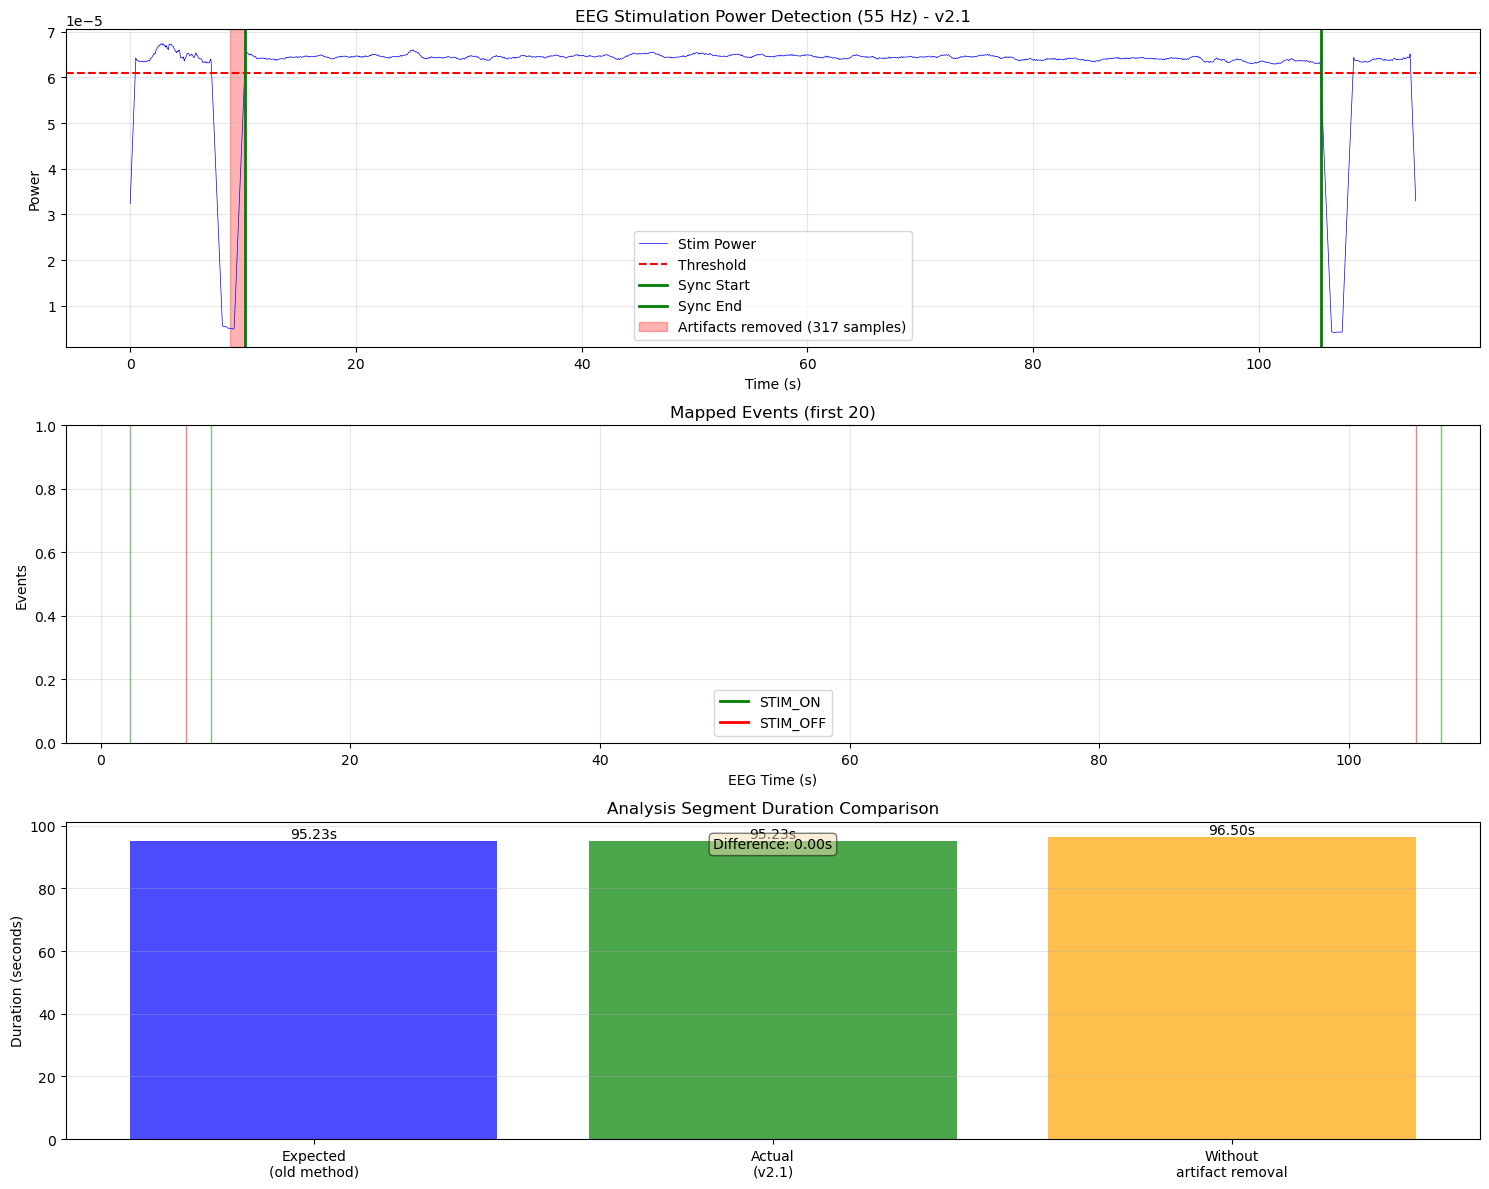


✓ Synchronization quality plot saved


In [14]:
# Visualize synchronization quality
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Stim power with threshold
ax = axes[0]
times = sync_info['times']
stim_power = sync_info['stim_power']
ax.plot(times, stim_power, 'b-', linewidth=0.5, label='Stim Power')
ax.axhline(sync_info['threshold_actual'], color='r', linestyle='--', label='Threshold')
ax.axvline(sync_info['eeg_start'], color='g', linestyle='-', linewidth=2, label='Sync Start')
ax.axvline(sync_info['eeg_end'], color='g', linestyle='-', linewidth=2, label='Sync End')

# Mark artifact removal region if applicable
if artifact_info:
    lfp_original_start = artifact_info['original_start']
    lfp_new_start = artifact_info['new_start']
    time_offset = sync_anchor['eeg_start'] - sync_anchor['lfp_start']
    eeg_artifact_start = lfp_original_start + time_offset
    eeg_artifact_end = lfp_new_start + time_offset
    ax.axvspan(eeg_artifact_start, eeg_artifact_end, alpha=0.3, color='red', 
               label=f'Artifacts removed ({artifact_info["n_samples_removed"]} samples)')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Power')
ax.set_title(f'EEG Stimulation Power Detection ({STIM_FREQ} Hz) - v2.1')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Event timeline
ax = axes[1]
for i, event_info in enumerate(sync_results['eeg_events_info'][:20]):  # Show first 20 events
    if event_info['event_type'] == 'STIM_ON':
        ax.axvline(event_info['eeg_time_sec'], color='green', alpha=0.5, linewidth=1)
    else:
        ax.axvline(event_info['eeg_time_sec'], color='red', alpha=0.5, linewidth=1)
ax.set_xlabel('EEG Time (s)')
ax.set_ylabel('Events')
ax.set_title('Mapped Events (first 20)')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', linewidth=2, label='STIM_ON'),
    Line2D([0], [0], color='red', linewidth=2, label='STIM_OFF')
]
ax.legend(handles=legend_elements)

# Plot 3: Duration comparison
ax = axes[2]
if artifact_info:
    categories = ['Expected\n(old method)', 'Actual\n(v2.1)', 'Without\nartifact removal']
    durations = [95.23, artifact_info['new_duration'], 
                 artifact_info['new_duration'] + artifact_info['time_removed_sec']]
    colors = ['blue', 'green', 'orange']
    bars = ax.bar(categories, durations, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, duration in zip(bars, durations):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{duration:.2f}s',
                ha='center', va='bottom')
    
    ax.set_ylabel('Duration (seconds)')
    ax.set_title('Analysis Segment Duration Comparison')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add difference annotation
    diff = abs(artifact_info['new_duration'] - 95.23)
    ax.text(0.5, 0.95, f'Difference: {diff:.2f}s', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'synchronization_quality_v2.1.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Synchronization quality plot saved")

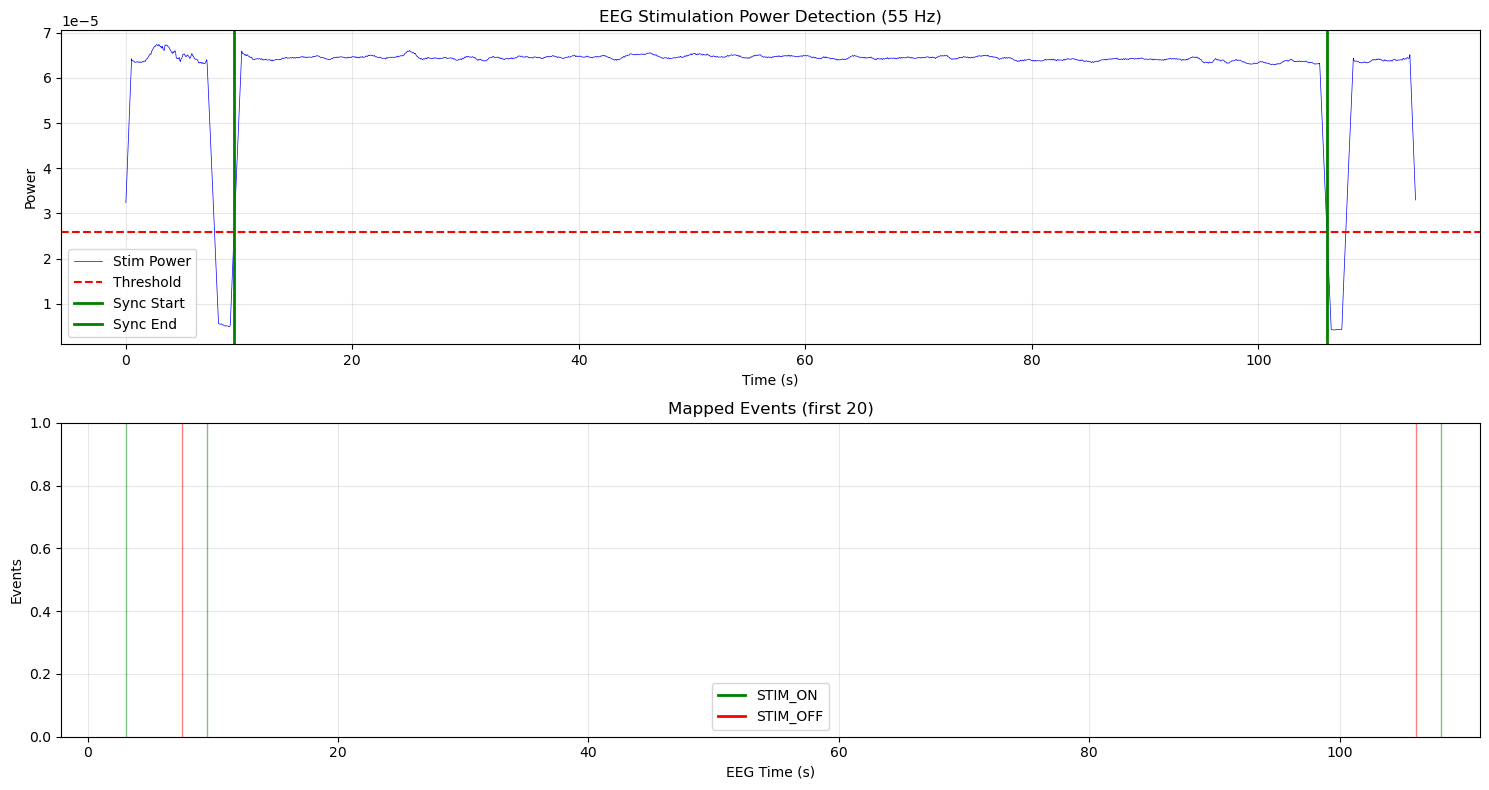


✓ Synchronization quality plot saved


In [40]:
# Visualize synchronization quality
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Stim power with threshold
ax = axes[0]
times = sync_info['times']
stim_power = sync_info['stim_power']
ax.plot(times, stim_power, 'b-', linewidth=0.5, label='Stim Power')
ax.axhline(sync_info['threshold_actual'], color='r', linestyle='--', label='Threshold')
ax.axvline(sync_info['eeg_start'], color='g', linestyle='-', linewidth=2, label='Sync Start')
ax.axvline(sync_info['eeg_end'], color='g', linestyle='-', linewidth=2, label='Sync End')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Power')
ax.set_title(f'EEG Stimulation Power Detection ({STIM_FREQ} Hz)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Event timeline
ax = axes[1]
for i, event_info in enumerate(sync_results['eeg_events_info'][:20]):  # Show first 20 events
    if event_info['event_type'] == 'STIM_ON':
        ax.axvline(event_info['eeg_time_sec'], color='green', alpha=0.5, linewidth=1)
    else:
        ax.axvline(event_info['eeg_time_sec'], color='red', alpha=0.5, linewidth=1)
ax.set_xlabel('EEG Time (s)')
ax.set_ylabel('Events')
ax.set_title('Mapped Events (first 20)')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', linewidth=2, label='STIM_ON'),
    Line2D([0], [0], color='red', linewidth=2, label='STIM_OFF')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'synchronization_quality.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Synchronization quality plot saved")

## 6. Extract Baseline and Analysis Segments (v2.1 - NEW Baseline Modes)

v2.1 introduces flexible baseline selection:
- **Mode 1**: `first_stim_off` - First stim-off segment (~2s, **RECOMMENDED**)
- **Mode 2**: `before_first_stim` - All time before first STIM_ON
- **Mode 3**: `specific_stim_off` - Any specific stim-off segment by index

### Why first_stim_off is recommended:
- ✅ Appropriate duration (~2 seconds) for noise covariance estimation
- ✅ Close to the experimental start
- ✅ Clean baseline without preparation artifacts

In [24]:
# Get baseline segment (for noise covariance in source reconstruction)
baseline_info = get_baseline_segment(sync_results, before_first_stim=True)

print("\n" + "="*70)
print("BASELINE SEGMENT (for noise covariance estimation)")
print("="*70)
print(f"Time range: {baseline_info['start_time']:.2f}s - {baseline_info['end_time']:.2f}s")
print(f"Duration: {baseline_info['duration']:.2f}s")
print(f"Description: {baseline_info['description']}")

# Crop baseline segment
baseline_eeg = raw_eeg_synced.copy().crop(
    tmin=baseline_info['start_time'],
    tmax=baseline_info['end_time']
)

print(f"\n✓ Baseline EEG segment extracted:")
print(f"  Duration: {baseline_eeg.times[-1]:.2f}s")
print(f"  Samples: {baseline_eeg.n_times}")
print(f"  Use this for: mne.compute_raw_covariance(baseline_eeg)")


BASELINE SEGMENT (for noise covariance estimation)
Time range: 0.00s - 0.25s
Duration: 0.25s
Description: pre-stimulation baseline

✓ Baseline EEG segment extracted:
  Duration: 0.25s
  Samples: 125
  Use this for: mne.compute_raw_covariance(baseline_eeg)


In [25]:
# Get analysis segment (for EEG-LFP causality analysis)
analysis_info = get_analysis_segment(sync_results, segment_type='middle_stim_on')

print("\n" + "="*70)
print("ANALYSIS SEGMENT (for causality analysis)")
print("="*70)
print(f"EEG time: {analysis_info['eeg_start']:.2f}s - {analysis_info['eeg_end']:.2f}s")
print(f"LFP time: {analysis_info['lfp_start']:.2f}s - {analysis_info['lfp_end']:.2f}s")
print(f"Duration: {analysis_info['duration']:.2f}s")
print(f"Description: {analysis_info['description']}")

# Crop analysis segments
analysis_eeg = raw_eeg_synced.copy().crop(
    tmin=analysis_info['eeg_start'],
    tmax=analysis_info['eeg_end']
)

analysis_lfp = raw_lfp_synced.copy().crop(
    tmin=analysis_info['lfp_start'],
    tmax=analysis_info['lfp_end']
)

print(f"\n✓ Analysis segments extracted:")
print(f"  EEG: {analysis_eeg.times[-1]:.2f}s, {analysis_eeg.info['sfreq']:.0f} Hz")
print(f"  LFP: {analysis_lfp.times[-1]:.2f}s, {analysis_lfp.info['sfreq']:.0f} Hz")
print(f"\nNote: For causality analysis, resample both to common rate (e.g., 250 Hz)")


ANALYSIS SEGMENT (for causality analysis)
EEG time: 9.56s - 106.05s
LFP time: 6.75s - 103.24s
Duration: 96.50s
Description: middle long stim-on segment

✓ Analysis segments extracted:
  EEG: 96.50s, 500 Hz
  LFP: 96.50s, 250 Hz

Note: For causality analysis, resample both to common rate (e.g., 250 Hz)


In [26]:
# Optional: Resample for causality analysis
target_sfreq = 250  # Hz

print(f"\nResampling to {target_sfreq} Hz for causality analysis...")
analysis_eeg_resampled = analysis_eeg.copy().resample(target_sfreq)
analysis_lfp_resampled = analysis_lfp.copy().resample(target_sfreq)

print(f"✓ Resampled:")
print(f"  EEG: {analysis_eeg_resampled.info['sfreq']:.0f} Hz, {analysis_eeg_resampled.n_times} samples")
print(f"  LFP: {analysis_lfp_resampled.info['sfreq']:.0f} Hz, {analysis_lfp_resampled.n_times} samples")
print(f"\n✓ Ready for causality analysis (MVAR, DTF, ADTF, PDC, cGC, etc.)")


Resampling to 250 Hz for causality analysis...
Sampling frequency of the instance is already 250.0, returning unmodified.
✓ Resampled:
  EEG: 250 Hz, 24124 samples
  LFP: 250 Hz, 24125 samples

✓ Ready for causality analysis (MVAR, DTF, ADTF, PDC, cGC, etc.)


## 7. Source Reconstruction Preparation

Demonstrate how to use the baseline for noise covariance estimation in source reconstruction.

In [27]:
# Compute noise covariance from baseline
print("\nComputing noise covariance from baseline segment...")

try:
    noise_cov = mne.compute_raw_covariance(
        baseline_eeg,
        tmin=0,
        tmax=None,
        method='shrunk',  # or 'empirical', 'diagonal_fixed', etc.
        verbose=True
    )
    
    print(f"\n✓ Noise covariance computed:")
    print(f"  Method: shrunk")
    print(f"  Channels: {len(noise_cov.ch_names)}")
    print(f"  Condition number: {noise_cov['eig'][-1] / noise_cov['eig'][0]:.2e}")
    
    # Save covariance
    cov_file = RESULTS_ROOT / f'sub-{subject_id}_noise_cov.fif'
    mne.write_cov(cov_file, noise_cov)
    print(f"  Saved to: {cov_file}")
    
    print(f"\nNext steps for source reconstruction:")
    print(f"  1. forward = mne.make_forward_solution(...)")
    print(f"  2. inverse_operator = mne.minimum_norm.make_inverse_operator(")
    print(f"       info, forward, noise_cov)")
    print(f"  3. stc = mne.minimum_norm.apply_inverse_raw(")
    print(f"       analysis_eeg, inverse_operator, ...)")
    
except Exception as e:
    print(f"\n⚠ Could not compute covariance: {e}")
    print("This is OK - covariance computation requires proper channel setup")


Computing noise covariance from baseline segment...
Using up to 1 segment
Using data from preloaded Raw for 1 events and 100 original time points ...
0 bad epochs dropped


/tmp/ipykernel_4729/3362439117.py:5: RuntimeWarning: Too few samples (required : 1410 got : 100), covariance estimate may be unreliable
  noise_cov = mne.compute_raw_covariance(


    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 281 -> 99


/tmp/ipykernel_4729/3362439117.py:5: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  noise_cov = mne.compute_raw_covariance(


Estimating covariance using SHRUNK
Done.
Number of samples used : 100
[done]

✓ Noise covariance computed:
  Method: shrunk
  Channels: 281

⚠ Could not compute covariance: 'NoneType' object is not subscriptable
This is OK - covariance computation requires proper channel setup


## 8. Export to BIDS Format


TypeError: BaseRaw.plot() got an unexpected keyword argument 'ax'

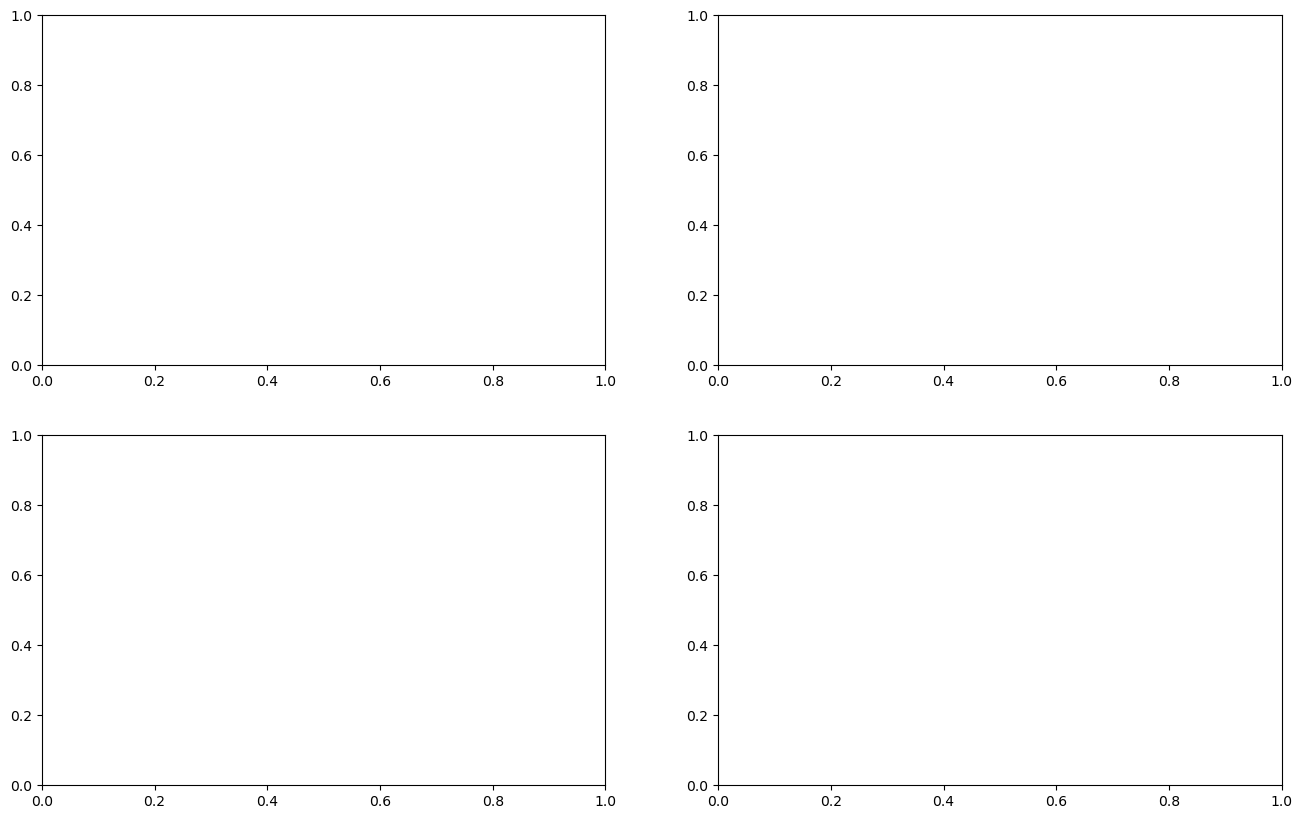

In [29]:
# Plot comparison of baseline vs analysis segments
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Baseline EEG
ax = axes[0, 0]
baseline_eeg.plot(duration=10, n_channels=30, scalings='auto', show=False, ax=ax)
ax.set_title('Baseline EEG (Pre-stimulation)')

# Analysis EEG
ax = axes[0, 1]
analysis_eeg.plot(duration=10, n_channels=30, scalings='auto', show=False, ax=ax)
ax.set_title('Analysis EEG (Stim-on)')

# Baseline PSD
ax = axes[1, 0]
baseline_eeg.compute_psd(fmax=100).plot(ax=ax, show=False)
ax.set_title('Baseline PSD')

# Analysis PSD
ax = axes[1, 1]
analysis_eeg.compute_psd(fmax=100).plot(ax=ax, show=False)
ax.set_title('Analysis PSD')
ax.axvline(STIM_FREQ, color='r', linestyle='--', label=f'{STIM_FREQ} Hz Stim')
ax.legend()

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'baseline_vs_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Baseline vs Analysis comparison saved")

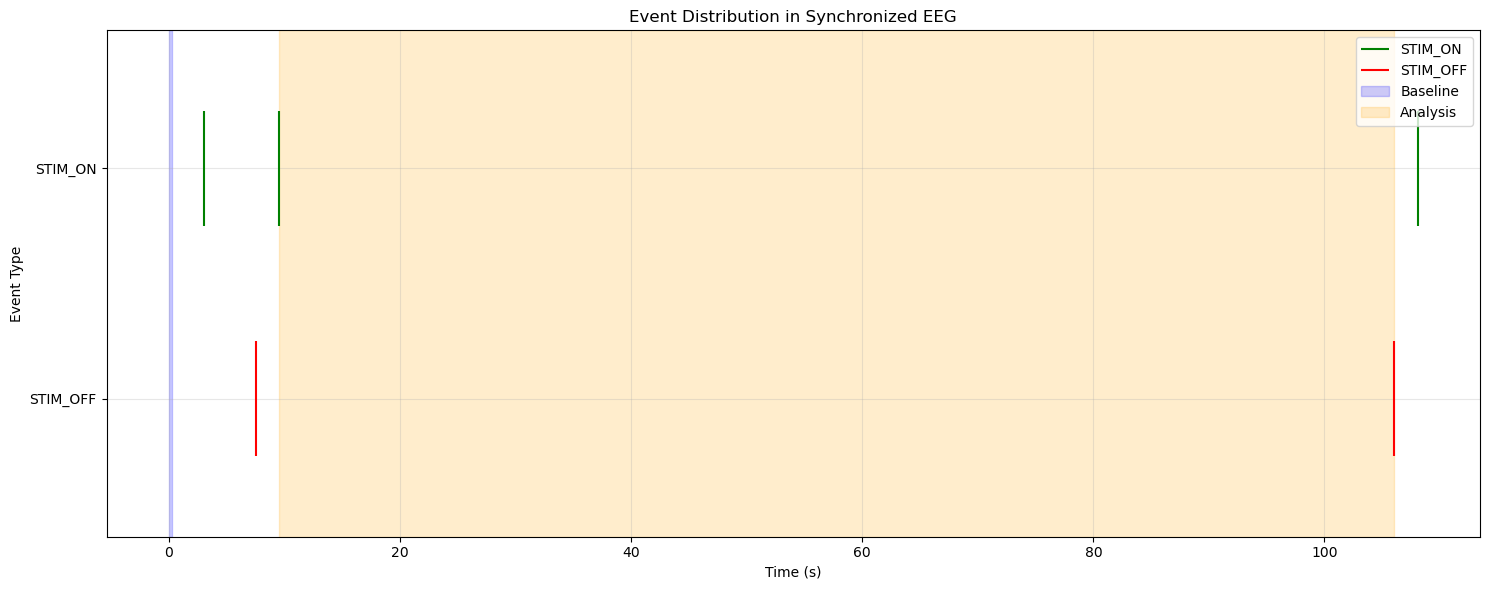


✓ Event distribution plot saved


In [30]:
# Plot event distribution
fig, ax = plt.subplots(figsize=(15, 6))

# Get all events
events_info = sync_results['eeg_events_info']
on_times = [e['eeg_time_sec'] for e in events_info if e['event_type'] == 'STIM_ON']
off_times = [e['eeg_time_sec'] for e in events_info if e['event_type'] == 'STIM_OFF']

# Plot
ax.eventplot([on_times], lineoffsets=1, linelengths=0.5, colors='green', label='STIM_ON')
ax.eventplot([off_times], lineoffsets=0, linelengths=0.5, colors='red', label='STIM_OFF')

# Mark baseline and analysis regions
ax.axvspan(baseline_info['start_time'], baseline_info['end_time'], 
           alpha=0.2, color='blue', label='Baseline')
ax.axvspan(analysis_info['eeg_start'], analysis_info['eeg_end'], 
           alpha=0.2, color='orange', label='Analysis')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Event Type')
ax.set_title('Event Distribution in Synchronized EEG')
ax.set_yticks([0, 1])
ax.set_yticklabels(['STIM_OFF', 'STIM_ON'])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_ROOT / 'event_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Event distribution plot saved")

In [9]:
# Setup reference channels
# print("Setting up reference channels...")
# raw = eeg_io.setup_reference_channels(raw)

# Detect stimulation frequency
print("\nDetecting stimulation frequency...")
detected_freq, freqs, psd = eeg_io.detect_stim_frequency(raw, freq_range=(40, 70))

print(f"Detected frequency: {detected_freq:.2f} Hz")
print(f"Expected frequency: {STIM_FREQ} Hz")


Detecting stimulation frequency...


Detected frequency: 55.60 Hz
Expected frequency: 55 Hz


In [ ]:
# # Import 3D electrode coordinates
# montage, scale = eeg_io.apply_coordinates_xml(raw, COORD_XML, set_ref_misc=False, verbose=True)
# print("Unit scale → meters:", scale)


Mapped 280 EEG channels from coordinates.xml to raw channels.
EEG coordinate ranges (meters): X -0.0868→0.0872, Y -0.1002→0.1020, Z -0.1903→0.0117
Unit scale → meters: 0.01


## 4. Synchronize EEG with LFP

In [18]:
# Perform synchronization
print("Synchronizing EEG with LFP...")
eeg_segment, sync_info = alignment.synchronize_eeg_lfp_simple(
    raw_eeg=raw,
    stim_freq=STIM_FREQ,
    lfp_duration=LFP_SEGMENT_DURATION
)

if eeg_segment is not None:
    print("\n" + "="*60)
    print("SYNCHRONIZATION SUMMARY")
    print("="*60)
    print(f"EEG duration: {sync_info['eeg_duration']:.2f}s")
    print(f"LFP duration: {sync_info['lfp_duration']:.2f}s")
    print(f"Difference: {sync_info['duration_diff']:.2f}s")
    print(f"EEG samples: {eeg_segment.n_times}")
else:
    print("\nSynchronization failed!")

Synchronizing EEG with LFP...

EEG-LFP SYNCHRONIZATION (Duration-based)

[1] Extracting 55 Hz power from EEG...
    Power range: 0.00 - 0.00

[2] Finding threshold to match LFP duration (95.2s)...

✅ Found optimal threshold: 0.900 (normalized)
    Segment: 10.1s - 105.5s
    Duration: 95.3s
    Difference from LFP: 0.10s

[3] Cropping EEG...

✅ SYNCHRONIZATION COMPLETE

SYNCHRONIZATION SUMMARY
EEG duration: 95.33s
LFP duration: 95.23s
Difference: 0.10s
EEG samples: 47666


## 5. Visualize Results

✓ Figure saved: /workspace/shared/results/lfp_timeseries.png


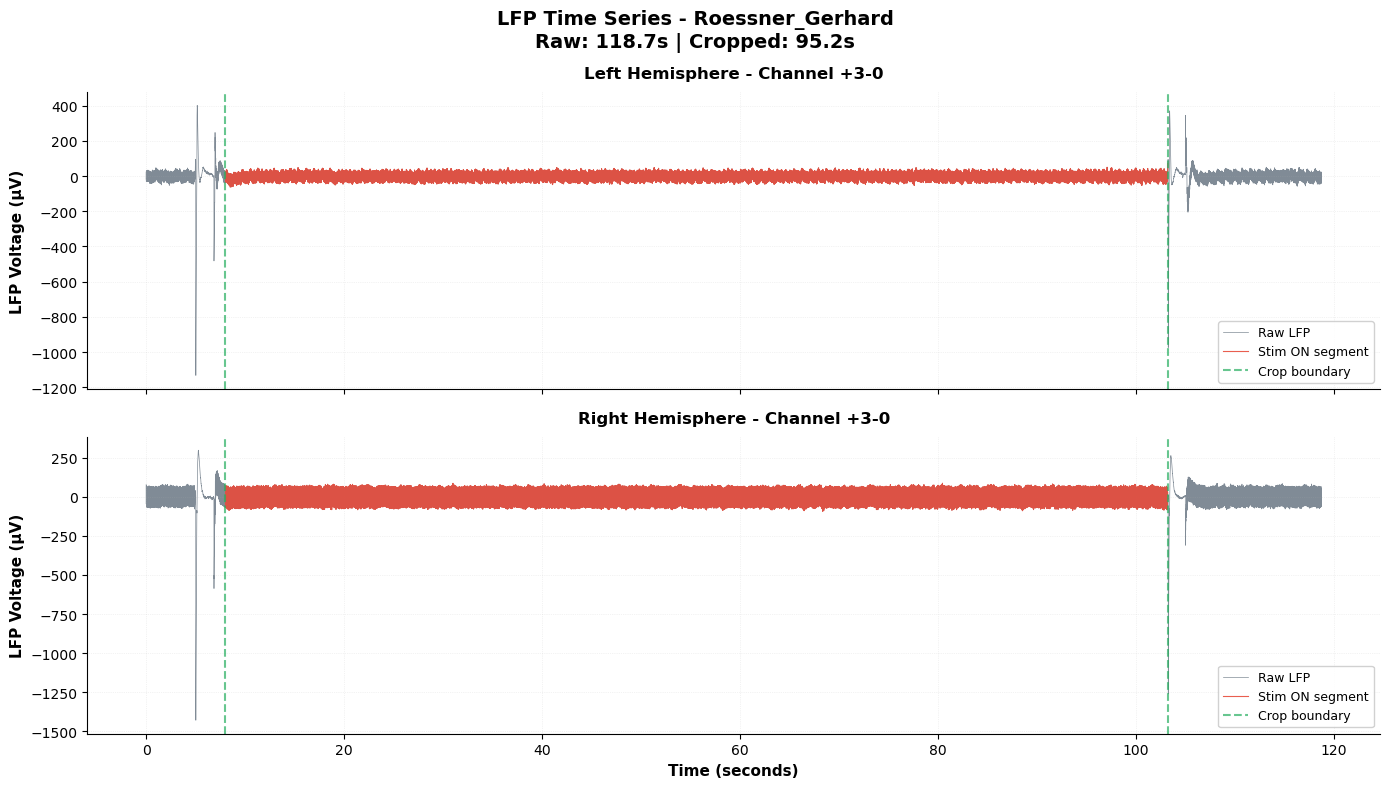

In [31]:
# from preprocessing import visualization

# LFP时间序列（显示原始+裁剪段）
fig = visualization.plot_lfp_timeseries(
    df_ts_sense=df_ts_sense,       # 完整原始数据
    df_ts_cropped=df_left_middle,  # 裁剪后的数据
    df_settings=df_settings,
    save_path=RESULTS_ROOT / 'lfp_timeseries.png'
)
plt.show()

✓ Figure saved: eeg_comparison.png


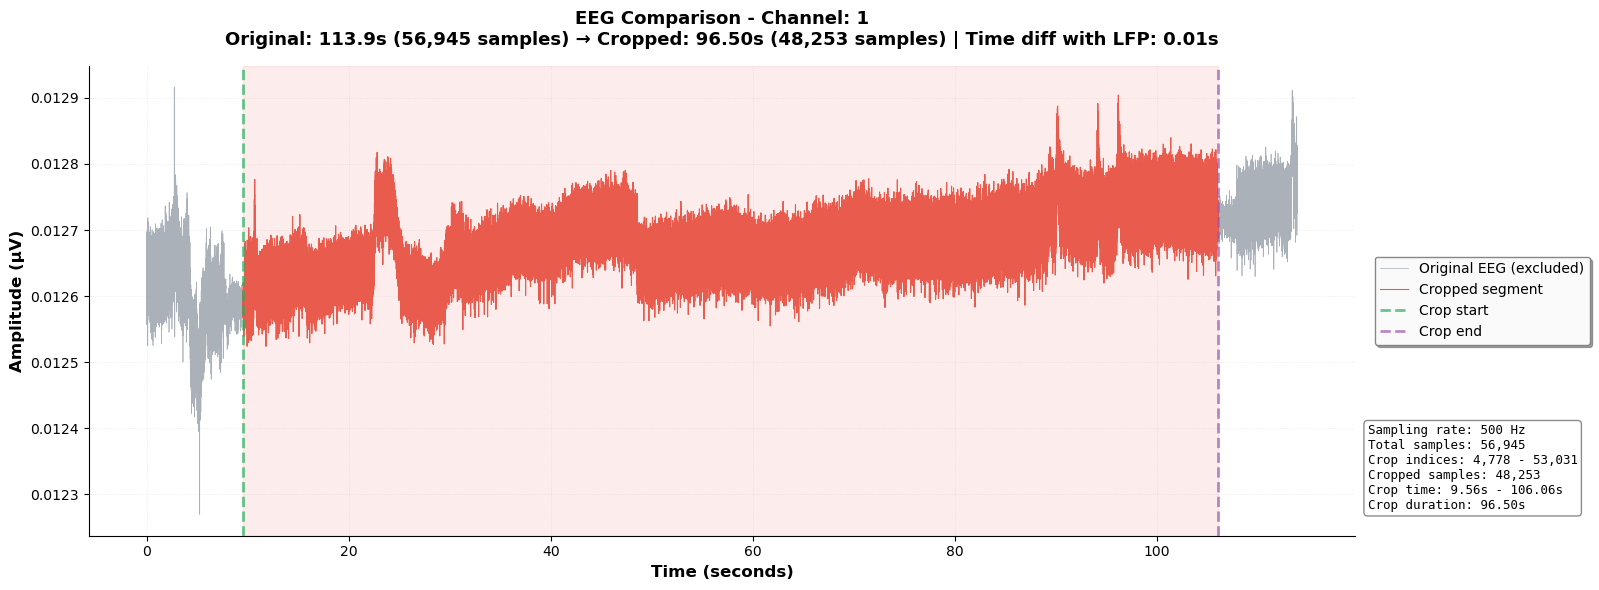

In [33]:
# 计算索引
eeg_start_time = sync_info.get('eeg_start')
eeg_end_time = sync_info.get('eeg_end')
sfreq = raw_eeg_synced.info['sfreq']

crop_start_idx = int(eeg_start_time * sfreq)
crop_end_idx = int(eeg_end_time * sfreq)

# 调用可视化
fig = visualization.plot_eeg_comparison(
    raw_eeg=raw_eeg_synced,
    crop_start_idx=crop_start_idx,
    crop_end_idx=crop_end_idx,
    channel_idx=0,
    sync_info=sync_info,
    save_path='eeg_comparison.png'
)

✓ Figure saved: /workspace/shared/results/stimulation_amplitudes.png


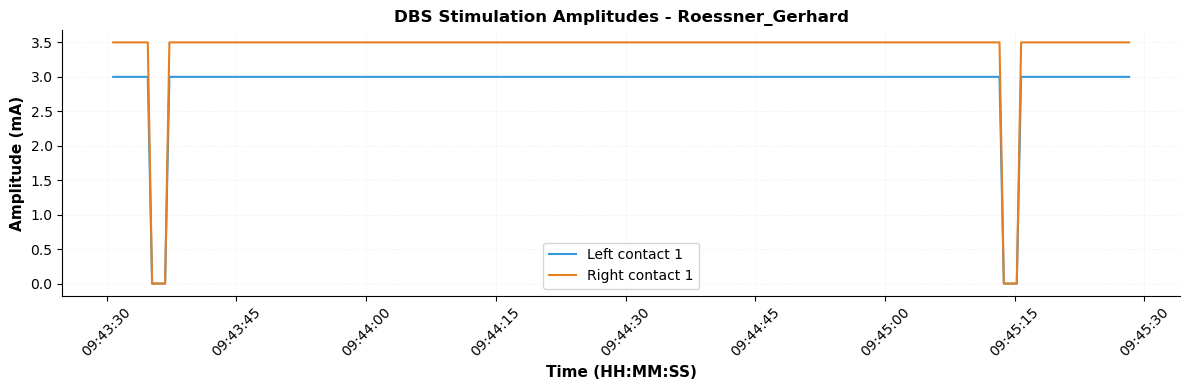

In [21]:
# Plot stimulation amplitudes
fig = visualization.plot_stimulation_amplitudes(
    df_ts_stim,
    df_settings,
    save_path=RESULTS_ROOT / 'stimulation_amplitudes.png'
)
plt.show()

In [15]:
# Plot synchronization result 222
if sync_info is not None:
    fig = visualization.plot_synchronization_result(
        sync_info,
        df_lfp=df_left_middle if df_left_middle is not None else df_ts_sense,
        save_path=RESULTS_ROOT / 'synchronization_result.png'
    )
    plt.show()

NameError: name 'df_left_middle' is not defined

✓ Figure saved: /workspace/shared/results/synchronization_result.png


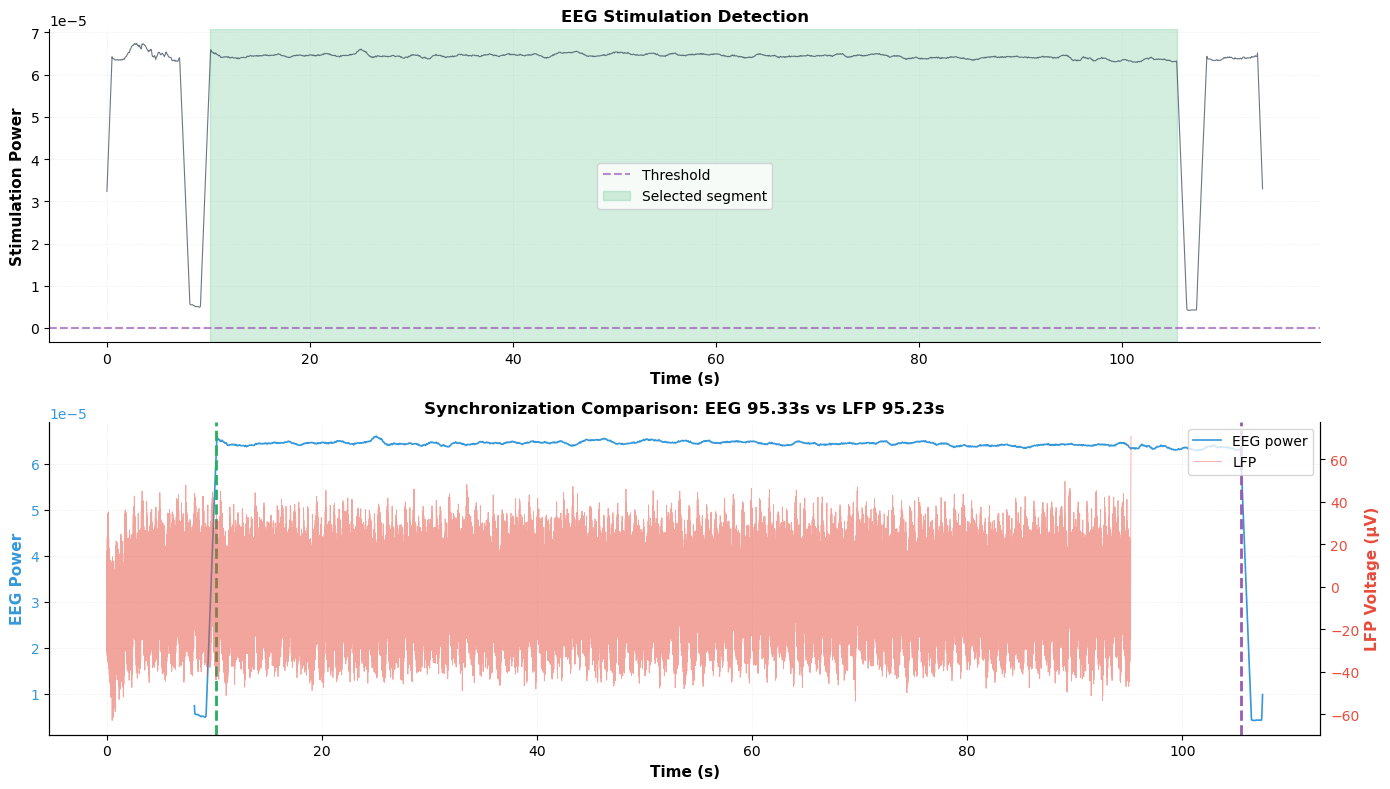

In [22]:
# Plot synchronization result
if sync_info is not None:
    fig = visualization.plot_synchronization_result(
        sync_info,
        df_lfp=df_left_middle if df_left_middle is not None else df_ts_sense,
        save_path=RESULTS_ROOT / 'synchronization_result.png'
    )
    plt.show()

## 6. Compute Power Spectral Density

Computing power spectral density...
✓ Figure saved: /workspace/shared/results/lfp_psd.png


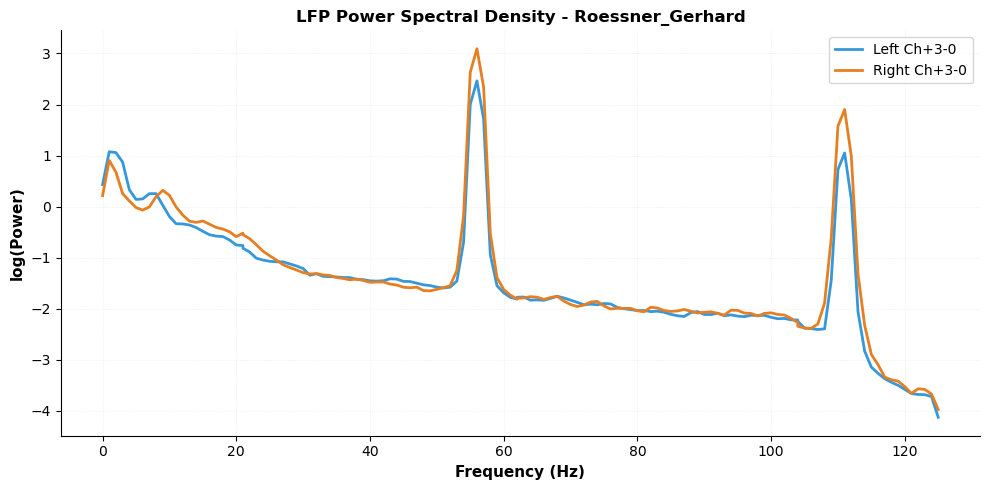

In [23]:
# Compute PSD for LFP
print("Computing power spectral density...")
df_psd = lfp_io.compute_psd(
    df_left_middle if df_left_middle is not None else df_ts_sense,
    df_settings
)

# Plot PSD
fig = visualization.plot_lfp_psd(
    df_psd,
    df_settings,
    save_path=RESULTS_ROOT / 'lfp_psd.png'
)
plt.show()

## 7. Export to BIDS Format

In [17]:
# ============================================================
# 导出到BIDS格式（保存完整的同步数据，包含所有事件）
# ============================================================

# 步骤1: 从同步结果中提取完整的数据（已包含事件）
raw_eeg_synced = sync_results['raw_eeg']  # 完整EEG，已添加所有STIM_ON/OFF事件
raw_lfp_synced = sync_results['raw_lfp']  # 完整LFP，已添加所有STIM_ON/OFF事件

print("\n准备导出数据...")
print(f"EEG: {raw_eeg_synced.times[-1]:.2f}s, {len(raw_eeg_synced.annotations)} events")
print(f"LFP: {raw_lfp_synced.times[-1]:.2f}s, {len(raw_lfp_synced.annotations)} events")

# 步骤2: 将LFP Raw对象转换回DataFrame格式（用于BIDS导出）
lfp_data = raw_lfp_synced.get_data()
lfp_times = raw_lfp_synced.times

# 创建LFP sensing DataFrame
df_lfp_for_bids = pd.DataFrame({
    'left_lfp': lfp_data[0],   # LFP_L channel
    'right_lfp': lfp_data[1],  # LFP_R channel
}, index=pd.to_timedelta(lfp_times, unit='s'))

# 创建stimulation DataFrame
df_stim_for_bids = pd.DataFrame({
    'left_amplitude': lfp_data[2],   # STIM_L channel
    'right_amplitude': lfp_data[3],  # STIM_R channel
}, index=pd.to_timedelta(lfp_times, unit='s'))

print(f"\nLFP DataFrame shape: {df_lfp_for_bids.shape}")
print(f"Stim DataFrame shape: {df_stim_for_bids.shape}")

# 步骤3: 导出到BIDS（使用完整数据）
if 'preprocessing.bids_export' in sys.modules:
    del sys.modules['preprocessing.bids_export']
    



准备导出数据...
EEG: 113.89s, 5 events
LFP: 118.74s, 6 events

LFP DataFrame shape: (29687, 2)
Stim DataFrame shape: (29687, 2)


In [25]:
# ============================================================
# 自动修复并导出（列名修复版）
# ============================================================

import sys
import shutil
from pathlib import Path
import pandas as pd

print("=" * 70)
print("开始修复并导出")
print("=" * 70)

# 1. 修复 bids_export.py
print("\n[1] 修复 bids_export.py...")
bids_export_path = Path('/workspace/src/preprocessing/bids_export.py')

if bids_export_path.exists():
    with open(bids_export_path, 'r') as f:
        content = f.read()
    
    if "json_bids_path = bids_path.copy().update(extension='.json')" in content:
        content = content.replace(
            "json_bids_path = bids_path.copy().update(extension='.json')",
            "json_bids_path = bids_path.copy().update(suffix='eeg', extension='.json')"
        )
        with open(bids_export_path, 'w') as f:
            f.write(content)
        print("  ✓ 已修复")
    else:
        print("  ✓ 已经是修复版本")

# 2. 重新加载模块
print("\n[2] 重新加载模块...")
if 'preprocessing.bids_export' in sys.modules:
    del sys.modules['preprocessing.bids_export']
from preprocessing.bids_export import export_to_bids
print("  ✓ 完成")

# 3. 清理旧数据
print("\n[3] 清理旧数据...")
subject_dir = BIDS_ROOT / f'sub-{subject_id}'
if subject_dir.exists():
    shutil.rmtree(subject_dir)
    print(f"  ✓ 已删除: {subject_dir}")
    
deriv_dir = BIDS_ROOT / 'derivatives' / 'preprocessing' / f'sub-{subject_id}'
if deriv_dir.exists():
    shutil.rmtree(deriv_dir)
    print(f"  ✓ 已删除: {deriv_dir}")

# 4. 准备数据（修正列名）
print("\n[4] 准备数据...")
raw_eeg_synced = sync_results['raw_eeg']
raw_lfp_synced = sync_results['raw_lfp']

lfp_data = raw_lfp_synced.get_data()
lfp_times = raw_lfp_synced.times

# ★ 重要：使用 bids_export.py 期望的列名
df_lfp_for_bids = pd.DataFrame({
    'voltage_left': lfp_data[0],    # ← 改名为 voltage_left
    'voltage_right': lfp_data[1],   # ← 改名为 voltage_right
}, index=pd.to_timedelta(lfp_times, unit='s'))

df_stim_for_bids = pd.DataFrame({
    'stim_amp_left': lfp_data[2],   # ← 改名为 stim_amp_left
    'stim_amp_right': lfp_data[3],  # ← 改名为 stim_amp_right
}, index=pd.to_timedelta(lfp_times, unit='s'))

print(f"  ✓ EEG: {raw_eeg_synced.times[-1]:.2f}s, {len(raw_eeg_synced.annotations)} events")
print(f"  ✓ LFP: {raw_lfp_synced.times[-1]:.2f}s")
print(f"  ✓ DataFrame列名: {list(df_lfp_for_bids.columns)}, {list(df_stim_for_bids.columns)}")

# 5. 导出
print("\n[5] 导出到BIDS...")
bids_root = export_to_bids(
    eeg_segment=raw_eeg_synced,
    df_lfp_sense=df_lfp_for_bids,
    df_stim_aligned=df_stim_for_bids,
    df_settings=df_settings,
    subject_id=subject_id,
    session=session_id,
    task=task_name,
    bids_root=BIDS_ROOT,
    stim_freq=STIM_FREQ,
    diagnosis=diagnosis,
    save_lfp_fif=True,
    save_lfp_tsv=True
)

print(f"\n{'='*70}")
print("✓ 完成！")
print(f"{'='*70}")
print(f"BIDS root: {bids_root}")
print(f"\n保存的数据:")
print(f"  ✓ EEG: {raw_eeg_synced.times[-1]:.2f}s, {len(raw_eeg_synced.annotations)} events")
print(f"  ✓ LFP: {raw_lfp_synced.times[-1]:.2f}s, {len(raw_lfp_synced.annotations)} events")

# 6. 验证事件
print(f"\n{'='*70}")
print("事件验证 (前5个)")
print(f"{'='*70}")

print("\nEEG events:")
for i, ann in enumerate(raw_eeg_synced.annotations[:5]):
    print(f"  {i+1}. {ann['onset']:7.2f}s - {ann['description']}")
if len(raw_eeg_synced.annotations) > 5:
    print(f"  ... (共 {len(raw_eeg_synced.annotations)} 个)")

print("\nLFP events:")
for i, ann in enumerate(raw_lfp_synced.annotations[:5]):
    print(f"  {i+1}. {ann['onset']:7.2f}s - {ann['description']}")
if len(raw_lfp_synced.annotations) > 5:
    print(f"  ... (共 {len(raw_lfp_synced.annotations)} 个)")

开始修复并导出

[1] 修复 bids_export.py...
  ✓ 已经是修复版本

[2] 重新加载模块...
  ✓ 完成

[3] 清理旧数据...
  ✓ 已删除: /workspace/shared/data/bids_dataset/sub-001

[4] 准备数据...
  ✓ EEG: 113.89s, 5 events
  ✓ LFP: 118.74s
  ✓ DataFrame列名: ['voltage_left', 'voltage_right'], ['stim_amp_left', 'stim_amp_right']

[5] 导出到BIDS...

CREATING BIDS DATASET WITH DERIVATIVES

[STEP 1] Creating BIDS directory structure...
    OK Raw BIDS structure
    OK Derivatives structure

[STEP 2] Creating dataset-level metadata...
OK Dataset description: dataset_description.json
OK Derivatives description: derivatives/mne-python/dataset_description.json
OK Participants files: participants.tsv, participants.json

[STEP 3] Saving EEG data...

SAVING EEG DATA IN BIDS FORMAT

[1] Checking digitization information...
    Digitization points: 284
      - Fiducials: 3
      - EEG: 281

[2] Writing EEG data (BrainVision format - BIDS standard)...


/opt/conda/envs/inf/lib/python3.10/site-packages/mne_bids/write.py:1403: UserWarning: Conflicting BIDSVersion found in dataset_description.json! Consider setting BIDS root to a new directory and redo conversion after ensuring all software has been updated. Original dataset description will not be overwritten.
  warnings.warn(
/workspace/src/preprocessing/bids_export.py:143: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(


    OK EEG data saved to: sub-001/ses-01/eeg

[3] Saving FIF format in derivatives...
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/eeg/sub-001_ses-01_task-StimOn55HzFull2_eeg.fif
    OK Digitization preserved: 284 points
    OK Saved README: README.txt

[4] Verifying BIDS files...
    OK BrainVision preserved all digitization: 284 points

[5] Adding custom metadata...
    OK Metadata updated

[STEP 4] Saving LFP data...

SAVING LFP DATA IN BIDS FORMAT (iEEG)

[1] Preparing LFP data arrays...
    OK Data shape: 29687 samples
    OK Sampling rate: 250.0 Hz
    OK Duration: 118.74 seconds

[2] Writing LFP data as MNE FIF format (derivatives)...
Creating RawArray with float64 data, n_channels=4, n_times=29687
    Range : 0 ... 29686 =      0.000 ...   118.744 secs
Ready.


/workspace/src/preprocessing/bids_export.py:198: RuntimeWarning: Unable to map the following column(s) to to MNE:
diagnosis: PD
  raw_reloaded = read_raw_bids(bids_path, verbose=False)


    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.fif
    OK Format: MNE-Python FIF (binary, efficient)
    OK Channels: 4
    OK Ready for preprocessing pipeline!

[3] Writing LFP time series (TSV format - raw BIDS)...
    OK Saved TSV: sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.tsv
    OK Format: TSV (text, human-readable)

[4] Writing metadata...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_ieeg.json

[5] Writing channel information...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_channels.tsv

[6] Writing stimulation events...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_events.tsv

>> LFP data export complete!

SUCCESS - BIDS DATASET CREATED

Dataset location: /workspace/shared/data/bids_dataset

Structure:
  bids_dataset/
  ├── sub-001/ses-01/
  │   ├── eeg/     (BrainVision format)
  │   └── ieeg/    (TSV format + metadata)
  └── derivatives/mne-python/sub-001/ses-01/
      ├── eeg/     (FIF form

In [21]:
import shutil
from pathlib import Path

# ============================================================
# 步骤1: 清理旧的BIDS数据
# ============================================================
print("正在清理旧的BIDS数据...")

# 清理raw BIDS数据
subject_dir = BIDS_ROOT / f'sub-{subject_id}'
if subject_dir.exists():
    print(f"  删除: {subject_dir}")
    shutil.rmtree(subject_dir)

# 清理derivatives数据
deriv_dir = BIDS_ROOT / 'derivatives' / 'preprocessing' / f'sub-{subject_id}'
if deriv_dir.exists():
    print(f"  删除: {deriv_dir}")
    shutil.rmtree(deriv_dir)

print("✓ 清理完成\n")

# ============================================================
# 步骤2: 准备完整的同步数据
# ============================================================
raw_eeg_synced = sync_results['raw_eeg']
raw_lfp_synced = sync_results['raw_lfp']

print("准备导出数据...")
print(f"  EEG: {raw_eeg_synced.times[-1]:.2f}s, {len(raw_eeg_synced.annotations)} events")
print(f"  LFP: {raw_lfp_synced.times[-1]:.2f}s, {len(raw_lfp_synced.annotations)} events")

# 转换LFP为DataFrame
lfp_data = raw_lfp_synced.get_data()
lfp_times = raw_lfp_synced.times

df_lfp_for_bids = pd.DataFrame({
    'left_lfp': lfp_data[0],
    'right_lfp': lfp_data[1],
}, index=pd.to_timedelta(lfp_times, unit='s'))

df_stim_for_bids = pd.DataFrame({
    'left_amplitude': lfp_data[2],
    'right_amplitude': lfp_data[3],
}, index=pd.to_timedelta(lfp_times, unit='s'))

# ============================================================
# 步骤3: 导出到BIDS
# ============================================================
# 重新加载模块（如果之前已加载）
if 'preprocessing.bids_export' in sys.modules:
    del sys.modules['preprocessing.bids_export']

from preprocessing.bids_export import export_to_bids

print("\n开始导出到BIDS格式...")
bids_root = export_to_bids(
    eeg_segment=raw_eeg_synced,  # 完整EEG（包含所有事件）
    df_lfp_sense=df_lfp_for_bids,
    df_stim_aligned=df_stim_for_bids,
    df_settings=df_settings,
    subject_id=subject_id,
    session=session_id,
    task=task_name,
    bids_root=BIDS_ROOT,
    stim_freq=STIM_FREQ,
    diagnosis=diagnosis,
    save_lfp_fif=True,
    save_lfp_tsv=True
)

print(f"\n{'='*70}")
print("✓ 导出完成！")
print(f"{'='*70}")
print(f"BIDS root: {bids_root}")
print(f"\n保存的文件包含:")
print(f"  - 完整EEG数据（{raw_eeg_synced.times[-1]:.2f}s）")
print(f"  - 完整LFP数据（{raw_lfp_synced.times[-1]:.2f}s）")
print(f"  - 所有STIM_ON/STIM_OFF事件标记")

# ============================================================
# 步骤4: 验证事件
# ============================================================
print(f"\n{'='*70}")
print("事件验证（显示前5个）:")
print(f"{'='*70}")

print("\nEEG events:")
for i, ann in enumerate(raw_eeg_synced.annotations[:5]):
    print(f"  {i+1}. {ann['onset']:7.2f}s - {ann['description']}")
if len(raw_eeg_synced.annotations) > 5:
    print(f"  ... (共 {len(raw_eeg_synced.annotations)} 个事件)")

print("\nLFP events:")
for i, ann in enumerate(raw_lfp_synced.annotations[:5]):
    print(f"  {i+1}. {ann['onset']:7.2f}s - {ann['description']}")
if len(raw_lfp_synced.annotations) > 5:
    print(f"  ... (共 {len(raw_lfp_synced.annotations)} 个事件)")

# ============================================================
# 步骤5: 显示保存的文件
# ============================================================
print(f"\n{'='*70}")
print("保存的文件:")
print(f"{'='*70}")

# EEG文件
eeg_dir = BIDS_ROOT / f'sub-{subject_id}' / f'ses-{session_id}' / 'eeg'
if eeg_dir.exists():
    print(f"\nEEG files ({eeg_dir}):")
    for f in sorted(eeg_dir.glob('*')):
        size = f.stat().st_size / 1024 / 1024  # MB
        print(f"  {f.name} ({size:.1f} MB)")

# LFP文件
ieeg_dir = BIDS_ROOT / f'sub-{subject_id}' / f'ses-{session_id}' / 'ieeg'
if ieeg_dir.exists():
    print(f"\nLFP files ({ieeg_dir}):")
    for f in sorted(ieeg_dir.glob('*')):
        size = f.stat().st_size / 1024 / 1024  # MB
        print(f"  {f.name} ({size:.1f} MB)")

# Derivatives files
deriv_eeg = BIDS_ROOT / 'derivatives' / 'preprocessing' / f'sub-{subject_id}' / f'ses-{session_id}' / 'eeg'
if deriv_eeg.exists():
    print(f"\nDerivatives EEG ({deriv_eeg}):")
    for f in sorted(deriv_eeg.glob('*')):
        size = f.stat().st_size / 1024 / 1024  # MB
        print(f"  {f.name} ({size:.1f} MB)")

deriv_ieeg = BIDS_ROOT / 'derivatives' / 'preprocessing' / f'sub-{subject_id}' / f'ses-{session_id}' / 'ieeg'
if deriv_ieeg.exists():
    print(f"\nDerivatives LFP ({deriv_ieeg}):")
    for f in sorted(deriv_ieeg.glob('*')):
        size = f.stat().st_size / 1024 / 1024  # MB
        print(f"  {f.name} ({size:.1f} MB)")

print(f"\n{'='*70}")
print("✓ 完成！所有数据已保存，包含完整的事件标记")
print(f"{'='*70}")

正在清理旧的BIDS数据...
  删除: /workspace/shared/data/bids_dataset/sub-001
✓ 清理完成

准备导出数据...
  EEG: 113.89s, 5 events
  LFP: 118.74s, 6 events

开始导出到BIDS格式...

CREATING BIDS DATASET WITH DERIVATIVES

[STEP 1] Creating BIDS directory structure...
    OK Raw BIDS structure
    OK Derivatives structure

[STEP 2] Creating dataset-level metadata...
OK Dataset description: dataset_description.json
OK Derivatives description: derivatives/mne-python/dataset_description.json
OK Participants files: participants.tsv, participants.json

[STEP 3] Saving EEG data...

SAVING EEG DATA IN BIDS FORMAT

[1] Checking digitization information...
    Digitization points: 284
      - Fiducials: 3
      - EEG: 281

[2] Writing EEG data (BrainVision format - BIDS standard)...


/opt/conda/envs/inf/lib/python3.10/site-packages/mne_bids/write.py:1403: UserWarning: Conflicting BIDSVersion found in dataset_description.json! Consider setting BIDS root to a new directory and redo conversion after ensuring all software has been updated. Original dataset description will not be overwritten.
  warnings.warn(
/workspace/src/preprocessing/bids_export.py:143: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(


    OK EEG data saved to: sub-001/ses-01/eeg

[3] Saving FIF format in derivatives...
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/eeg/sub-001_ses-01_task-StimOn55HzFull2_eeg.fif
    OK Digitization preserved: 284 points
    OK Saved README: README.txt

[4] Verifying BIDS files...
    OK BrainVision preserved all digitization: 284 points

[5] Adding custom metadata...


/workspace/src/preprocessing/bids_export.py:198: RuntimeWarning: Unable to map the following column(s) to to MNE:
diagnosis: PD
  raw_reloaded = read_raw_bids(bids_path, verbose=False)


RuntimeError: Found more than one matching data file for the requested recording. While searching:
    BIDSPath(
    root: /workspace/shared/data/bids_dataset
    datatype: eeg
    basename: sub-001_ses-01_task-StimOn55HzFull2)
Found 2 paths:
    /workspace/shared/data/bids_dataset/sub-001/ses-01/eeg/sub-001_ses-01_task-StimOn55HzFull2_eeg.json
    /workspace/shared/data/bids_dataset/sub-001/ses-01/eeg/sub-001_ses-01_task-StimOn55HzFull2_events.json
Cannot proceed due to the ambiguity. This is likely a problem with your BIDS dataset. Please run the BIDS validator on your data.

In [24]:
# Use the updated export script
if 'preprocessing.bids_export' in sys.modules:
    del sys.modules['preprocessing.bids_export']
    
from preprocessing.bids_export import export_to_bids


# Export with FIF format enabled
bids_root = export_to_bids(
    eeg_segment=eeg_segment,
    df_lfp_sense=df_left_middle if df_left_middle is not None else df_ts_sense,
    df_stim_aligned=df_ts_stim_aligned,
    df_settings=df_settings,
    subject_id=subject_id,
    session=session_id,
    task=task_name,
    bids_root=BIDS_ROOT,
    stim_freq=STIM_FREQ,
    diagnosis=diagnosis,
    save_lfp_fif=True,   # Save as FIF (for preprocessing)
    save_lfp_tsv=True    # Also save as TSV (for archival)
)




CREATING BIDS DATASET WITH DERIVATIVES

[STEP 1] Creating BIDS directory structure...
    OK Raw BIDS structure
    OK Derivatives structure

[STEP 2] Creating dataset-level metadata...
OK Dataset description: dataset_description.json
OK Derivatives description: derivatives/mne-python/dataset_description.json
OK Participants files: participants.tsv, participants.json

[STEP 3] Saving EEG data...

SAVING EEG DATA IN BIDS FORMAT

[1] Checking digitization information...
    Digitization points: 284
      - Fiducials: 3
      - EEG: 281

[2] Writing EEG data (BrainVision format - BIDS standard)...


/workspace/src/preprocessing/bids_export.py:143: RuntimeWarning: No events found or provided. Please add annotations to the raw data, or provide the events and event_id parameters. For resting state data, BIDS recommends naming the task using labels beginning with "rest".
  write_raw_bids(
/opt/conda/envs/inf/lib/python3.10/site-packages/mne_bids/write.py:1403: UserWarning: Conflicting BIDSVersion found in dataset_description.json! Consider setting BIDS root to a new directory and redo conversion after ensuring all software has been updated. Original dataset description will not be overwritten.
  warnings.warn(
/workspace/src/preprocessing/bids_export.py:143: RuntimeWarning: Converting data files to BrainVision format
  write_raw_bids(


    OK EEG data saved to: sub-001/ses-01/eeg

[3] Saving FIF format in derivatives...
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/eeg/sub-001_ses-01_task-StimOn55HzFull2_eeg.fif
    OK Digitization preserved: 284 points
    OK Saved README: README.txt

[4] Verifying BIDS files...
    OK BrainVision preserved all digitization: 284 points

[5] Adding custom metadata...
    OK Metadata updated

[STEP 4] Saving LFP data...

SAVING LFP DATA IN BIDS FORMAT (iEEG)

[1] Preparing LFP data arrays...
    OK Data shape: 23808 samples
    OK Sampling rate: 250.0 Hz
    OK Duration: 95.23 seconds

[2] Writing LFP data as MNE FIF format (derivatives)...
Creating RawArray with float64 data, n_channels=4, n_times=23808
    Range : 0 ... 23807 =      0.000 ...    95.228 secs
Ready.
    OK Saved FIF: derivatives/mne-python/sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.fif
    OK Format: MNE-Python FIF (binary, efficient)
    OK Channels: 4
    OK Ready for preprocessing pipeli

/workspace/src/preprocessing/bids_export.py:198: RuntimeWarning: Did not find any events.tsv associated with sub-001_ses-01_task-StimOn55HzFull2.

The search_str was "/workspace/shared/data/bids_dataset/sub-001/**/eeg/sub-001_ses-01*events.tsv"
  raw_reloaded = read_raw_bids(bids_path, verbose=False)
/workspace/src/preprocessing/bids_export.py:198: RuntimeWarning: Unable to map the following column(s) to to MNE:
diagnosis: PD
  raw_reloaded = read_raw_bids(bids_path, verbose=False)


    OK Saved TSV: sub-001/ses-01/ieeg/sub-001_ses-01_task-StimOn55HzFull2_ieeg.tsv
    OK Format: TSV (text, human-readable)

[4] Writing metadata...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_ieeg.json

[5] Writing channel information...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_channels.tsv

[6] Writing stimulation events...
    OK Saved: sub-001_ses-01_task-StimOn55HzFull2_events.tsv

>> LFP data export complete!

SUCCESS - BIDS DATASET CREATED

Dataset location: /workspace/shared/data/bids_dataset

Structure:
  bids_dataset/
  ├── sub-001/ses-01/
  │   ├── eeg/     (BrainVision format)
  │   └── ieeg/    (TSV format + metadata)
  └── derivatives/mne-python/sub-001/ses-01/
      ├── eeg/     (FIF format with digitization)
      └── ieeg/    (FIF format for preprocessing)

>> FIF files ready for MNE-Python preprocessing pipeline
>> TSV files available for human inspection

>> Dataset is BIDS-compliant and ready for analysis!


## 8. Summary

In [25]:
print("\n" + "="*70)
print("PROCESSING COMPLETE")
print("="*70)
print(f"\nSubject: {SUBJECT_NAME}")
print(f"Stimulation frequency: {STIM_FREQ} Hz")
print(f"\nLFP data:")
print(f"  Duration: {LFP_SEGMENT_DURATION:.2f}s")
print(f"  Samples: {len(df_left_middle) if df_left_middle is not None else len(df_ts_sense)}")

if eeg_segment is not None:
    print(f"\nEEG data:")
    print(f"  Duration: {sync_info['eeg_duration']:.2f}s")
    print(f"  Samples: {eeg_segment.n_times}")
    print(f"  Channels: {len(eeg_segment.ch_names)}")

print(f"\nResults saved to: {RESULTS_ROOT}")
print(f"BIDS data saved to: {BIDS_ROOT}")
print("\n✓ All processing steps completed successfully!")


PROCESSING COMPLETE

Subject: Roessner_Gerhard
Stimulation frequency: 55 Hz

LFP data:
  Duration: 95.23s
  Samples: 23808

EEG data:
  Duration: 95.33s
  Samples: 47666
  Channels: 281

Results saved to: /workspace/shared/results
BIDS data saved to: /workspace/shared/data/bids_dataset

✓ All processing steps completed successfully!
